In [45]:
from matplotlib import pyplot as plt

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer

import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from time import perf_counter

In [42]:
# parameters
N_DOCS = -1 # all documents (takes a while to preprocess!)
N_TOPICS = 20 # number of topics to extract (rank)
SOLVER = "cd" # NMF solver
INIT = "nndsvda" # initialization method
MAX_ITER = 1000 # number of iterations in the NMF
N_TOP_WORDS = 10 # number of words to display for each topic
RANDOM_STATE = 0 # for reproducability

In [33]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")

[nltk_data] Downloading package wordnet to /home/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/max/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/max/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
# load dataset
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=RANDOM_STATE,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)

In [35]:
# preprocess data
def preprocess(text: str) -> str:
    tokens = word_tokenize(text.lower())
    cleaned = [token for token in tokens if token.isalnum()]
    nouns = [word for (word, pos) in pos_tag(cleaned) if pos in ("NN", "NNS", "NNP")]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(noun, pos="n") for noun in nouns]
    return " ".join(lemmatized)

data_pped = map(preprocess, data[:N_DOCS])

In [36]:
# vectorize the documents using term frequency-inverse document frequency
vectorizer = TfidfVectorizer(stop_words="english")
doc_vectors = vectorizer.fit_transform(data_pped)

### Extraction of the 20 Topics

In [37]:
# use NMF to decompose the document vectors into topic vectors
nmf = NMF(n_components=N_TOPICS, solver=SOLVER, init=INIT, random_state=RANDOM_STATE, max_iter=MAX_ITER)
topic_vectors = nmf.fit_transform(doc_vectors)

In [38]:
# print the topics with their most occuring words
for topic_idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-N_TOP_WORDS-1:-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    print(f"Topic {topic_idx}:", *top_words)

Topic 0: people thing time group way government life question world child
Topic 1: window manager application font program server memory screen version display
Topic 2: drive disk scsi controller hd mac tape ide cable computer
Topic 3: team player league season fan hockey run point baseball nhl
Topic 4: chip key encryption clipper phone algorithm government escrow security bit
Topic 5: card video bus slot memory port controller pc ram mode
Topic 6: car engine dealer mile price model owner speed tire power
Topic 7: thanks advance hi info anybody question reply help information response
Topic 8: god jesus christian faith christ belief life religion word truth
Topic 9: file directory format disk program ftp help utility image copy
Topic 10: program space time data image code source software machine application
Topic 11: problem error solution duo mouse apple machine screen help battery
Topic 12: driver version printer mouse diamond bb site mode ftp device
Topic 13: law gun right state gov

### Solver comparison

In [46]:
solvers = ["cd", "mu"]
for i, solver in enumerate(solvers):
    nmf = NMF(n_components=N_TOPICS, solver=solver, init=INIT, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    t0 = perf_counter()
    nmf.fit_transform(doc_vectors)
    t = perf_counter()
    time = t - t0
    print(f"reconstruction error for solver '{solver}': {nmf.reconstruction_err_} in {time} seconds.")

reconstruction error for solver 'cd': 101.34793505032103 in 10.457680419000098 seconds.
reconstruction error for solver 'mu': 101.36953914325987 in 6.725636825984111 seconds.


### Initialization comparison

In [44]:
inits = ["random", "nndsvd", "nndsvda", "nndsvdar"]
for i, init in enumerate(inits):
    nmf = NMF(n_components=N_TOPICS, solver=SOLVER, init=init, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    nmf.fit_transform(doc_vectors)
    print(f"reconstruction error for '{init}': {nmf.reconstruction_err_}")

reconstruction error for 'random': 101.37013310805062
reconstruction error for 'nndsvd': 101.34793376680442
reconstruction error for 'nndsvda': 101.34793505032103
reconstruction error for 'nndsvdar': 101.3479350876765


### Comparison of different ranks

In [26]:
ranks = np.arange(1, 26)
errors = np.zeros(len(ranks))
for i, rank in enumerate(ranks):
    print(f"Calculating rank {rank:2} approximation...", end=" ")
    nmf = NMF(n_components=rank, solver=SOLVER, init=init, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    nmf.fit_transform(doc_vectors)
    errors[i] = nmf.reconstruction_err_
    print("done.")

Calculating rank  1 approximation...done.
Calculating rank  2 approximation...done.
Calculating rank  3 approximation...done.
Calculating rank  4 approximation...done.
Calculating rank  5 approximation...done.
Calculating rank  6 approximation...done.
Calculating rank  7 approximation...done.
Calculating rank  8 approximation...done.
Calculating rank  9 approximation...done.
Calculating rank 10 approximation...done.
Calculating rank 11 approximation...done.
Calculating rank 12 approximation...done.
Calculating rank 13 approximation...done.
Calculating rank 14 approximation...done.
Calculating rank 15 approximation...done.
Calculating rank 16 approximation...done.
Calculating rank 17 approximation...done.
Calculating rank 18 approximation...done.
Calculating rank 19 approximation...done.
Calculating rank 20 approximation...done.
Calculating rank 21 approximation...done.
Calculating rank 22 approximation...done.
Calculating rank 23 approximation...done.
Calculating rank 24 approximation.

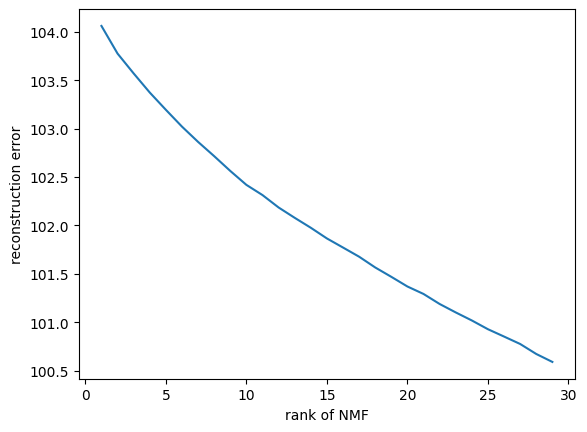

In [29]:
plt.plot(ranks, errors)
plt.xlabel("NMF approximation rank")
plt.ylabel("reconstruction error")
plt.show()